In [103]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import binom
from functools import partial
import seaborn as sns
np.set_printoptions(suppress=True)

from deep_bayes.models import BayesFlow
from deep_bayes.training import train_online
from deep_bayes.losses import maximum_likelihood_loss
from deep_bayes.viz import plot_true_est_scatter, plot_true_est_posterior
import deep_bayes.diagnostics as diag

In [45]:
if int(tf.__version__[0]) == 1:
    tf.enable_eager_execution()

In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Forward model priors and generator

In [47]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------
    
    Arguments:
    batch_size : int -- the number of samples to draw from the prior
    ----------
    
    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """
    
    # Just as a toy example, sample from 4-D unit Gaussian
    mu = stats.norm(0, 1).rvs(batch_size)
    scale = stats.invgamma(3, 0.5).rvs(batch_size)
    return np.c_[mu, scale]

In [48]:
def forward_model(params, n_obs, **args):
    """
    Runs the forward model ones, i.e., generates a sample from p(x|theta).
    ----------
    
    Arguments:
    params : np.ndarray of shape (theta_dim, ) -- the data generating parameters
    n_obs  : int -- the numebr of observations to draw from p(x|theta)
    ----------
    
    Output:
    x      : np.ndarray of shape (n_obs, x_dim)
    """
    
    # Again, toy
    x = np.random.normal(loc=params[:, 0], 
                         scale=params[:, 1], 
                         size=(n_obs, params.shape[0])).T[:, :, np.newaxis]
    return x

In [49]:
def data_generator(batch_size, n_obs=None, n_obs_min=1, n_obs_max=500, to_tensor=True, **args):
    """
    Runs the forward model 'batch_size' times by first sampling fromt the prior
    theta ~ p(theta) and running x ~ p(x|theta).
    ----------
    
    Arguments:
    batch_size : int -- the number of samples to draw from the prior
    n_obs      : int -- the numebr of observations to draw from p(x|theta)
    to_tensor  : boolean -- converts theta and x to tensors if True
    ----------
    
    Output:
    A dictionary with key-value pairs:
    theta : tf.Tensor or np.ndarray of shape (batch_size, theta_dim) - the data gen parameters 
    x     : tf.Tensor of np.ndarray of shape (batch_size, n_obs, x_dim)  - the generated data
    """
    
    # Sample from prior
    # theta is a np.array of shape (batch_size, theta_dim)
    theta = prior(batch_size)
    
    if n_obs is None:
        n_obs = np.random.randint(n_obs_min, n_obs_max+1)
    
    # Generate data
    # x is a np.ndarray of shape (batch_size, n_obs, x_dim)
    x = forward_model(theta, n_obs=n_obs)
    
    # Convert to tensor, if specified 
    if to_tensor:
        theta = tf.convert_to_tensor(theta, dtype=tf.float32)
        x = tf.convert_to_tensor(x, dtype=tf.float32)
    return {'theta': theta, 'x': x}

In [102]:
def plot_sbc(theta_samples, theta_test, param_names, bins=25,
            figsize=(24, 12), interval=0.99, show=True, filename=None, font_size=12):
    """
    Plots the simulation-based posterior checking histograms as advocated by Talts et al. (2018).
    """

    # Plot settings
    plt.rcParams['font.size'] = font_size
    N = int(theta_test.shape[0])
    

    f, axarr = plt.subplots(1, 2, figsize=figsize)
    axarr = axarr.flat

    # Convert theta test to numpy
    theta_test = theta_test.numpy()

    # Compute ranks (using broadcasting)    
    ranks = np.sum(theta_samples < theta_test, axis=0)
    
    # Compute interval
    endpoints = binom.interval(interval, N, 1 / (bins+1))

    # Plot histograms
    for j in range(len(param_names)):
        
        # Add interval
        axarr[j].axhspan(endpoints[0], endpoints[1], facecolor='gray', alpha=0.3)
        axarr[j].axhline(np.mean(endpoints), color='gray', zorder=0, alpha=0.5)
        
        sns.distplot(ranks[:, j], kde=False, ax=axarr[j], color='#a34f4f',
                         hist_kws=dict(edgecolor="k", linewidth=1,alpha=1.), bins=bins)
        
        axarr[j].set_title(param_names[j])
        axarr[j].spines['right'].set_visible(False)
        axarr[j].spines['top'].set_visible(False)
        if j == 0:
            axarr[j].set_xlabel('Rank statistic')
        axarr[j].get_yaxis().set_ticks([])
    f.tight_layout()
    
    # Show, if specified
    if show:
        plt.show()
        
    # Save if specified
    if filename is not None:
        f.savefig("figures/{}.png".format(filename), dpi=300)

In [75]:
class InvariantModule(tf.keras.Model):
    """Implements an invariant nn module as proposed by Bloem-Reddy and Teh (2019)."""

    def __init__(self, meta):
        """
        Creates an invariant function with mean pooling.
        ----------

        Arguments:
        meta : dict -- a dictionary with hyperparameter name - values
        """

        super(InvariantModule, self).__init__()


        self.module = tf.keras.Sequential([
            tf.keras.layers.Dense(**meta['dense_inv_args'])
            for _ in range(meta['n_dense_inv'])
        ])

            
        self.post_pooling_dense = tf.keras.Sequential([
            tf.keras.layers.Dense(**meta['dense_inv_args'])
            for _ in range(meta['n_dense_inv'])
        ])
        

    def call(self, x, **args):
        """
        Transofrms the input into an invariant representation.
        ----------

        Arguments:
        x : tf.Tensor of shape (batch_size, n, m) - the input where n is the 'time' or 'samples' dimensions
            over which pooling is performed and m is the input dimensionality
        ----------

        Returns:
        out : tf.Tensor of shape (batch_size, h_dim) -- the pooled and invariant representation of the input
        """

        # Embed
        x_emb = self.module(x)
        w_x = tf.reduce_sum(x_emb, axis=1)
        out = self.post_pooling_dense(w_x)
        return out

# Training hyperparameters

In [85]:
# Network hyperparameters
inv_meta = {
    'n_units': [32, 32],
    'activation': 'elu',
    'w_decay': 0.0,
    'initializer': 'glorot_uniform'
}
n_inv_blocks = 2

summary_meta = {
    'n_dense_inv'      :  3,
    'dense_inv_args'   :  dict(units=64, activation='relu', kernel_initializer='glorot_normal'),
}


# Forward model hyperparameters
param_names = [r'$\mu$', r'$\sigma$']
theta_dim = len(param_names)
n_test = 300

# Training and optimizer hyperparameters
ckpt_file = "gaussian_tester"
batch_size = 32
epochs = 100
iterations_per_epoch = 1000
n_samples_posterior = 2000
clip_value = 5.

starter_learning_rate = 0.0001
global_step = tf.Variable(0, dtype=tf.int32)
decay_steps = 1000
decay_rate = .95
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, decay_steps, decay_rate)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [86]:
data_generator = partial(data_generator, n_obs=None)

## Create test data

In [96]:
%%time
test_data = data_generator(n_test, n_obs=60)

Wall time: 3.51 ms


In [88]:
test_data_sbc = data_generator(5000)
# theta_samples = np.concatenate([model.sample(x, 250, to_numpy=True) 
#                                 for x in tf.split(test_data_sbc['x'], 10, axis=0)], axis=1)

## Create networks

In [97]:
summary_net = InvariantModule(summary_meta)
model = BayesFlow(inv_meta, n_inv_blocks, theta_dim, summary_net=summary_net, permute=True)

## Compile 
<p>In other words, run and plot performance of untrained networks.</p>

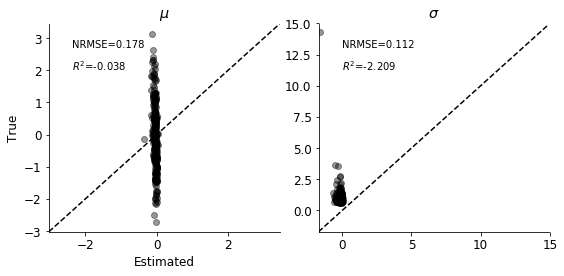

In [90]:
plot_true_est_scatter(model, test_data['x'], test_data['theta'], n_samples_posterior, param_names, figsize=(8, 4))

## Manage checkpoints

In [129]:
# checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
# manager = tf.train.CheckpointManager(checkpoint, './checkpoints/{}'.format(ckpt_file), max_to_keep=3)
# checkpoint.restore(manager.latest_checkpoint)
# if manager.latest_checkpoint:
#     print("Restored from {}".format(manager.latest_checkpoint))
# else:
#     print("Initializing from scratch.")

In [67]:
# starter_learning_rate = 0.0001
# global_step = tf.Variable(0, dtype=tf.int32)
# decay_steps = 1000
# decay_rate = .95
# learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, decay_steps, decay_rate)
# optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

# Train networks

In [101]:
# # %%time
# for ep in range(1, epochs+1):
#     with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
#         losses = train_online(model=model, 
#                               optimizer=optimizer, 
#                               data_gen=data_generator, 
#                               loss_fun=maximum_likelihood_loss, 
#                               iterations=iterations_per_epoch,
#                               batch_size=batch_size,
#                               p_bar=p_bar,
#                               clip_value=clip_value,
#                               global_step=global_step)
        
        
#         plot_true_est_scatter(model, test_data['x'], test_data['theta'], n_samples_posterior, param_names, figsize=(8, 4))
#         theta_samples = np.concatenate([model.sample(x, 250, to_numpy=True) 
#                                 for x in tf.split(test_data_sbc['x'], 10, axis=0)], axis=1)
#         plot_sbc(theta_samples, test_data_sbc['theta'], param_names, figsize=(22, 6))

# #         # Store checkpoint
# #         manager.save()

## Plot posterior variance over N

In [99]:
stds = []
for n_obs_test in range(1, 501, 5):
    
    # Simulate and sample
    test_data = data_generator(n_test, n_obs=n_obs_test)
    post_samples = model.sample(test_data['x'], n_samples=5000, to_numpy=True)
    mean_std = np.mean(np.std(post_samples, axis=0), axis=0)
    
    stds.append(mean_std)
stds = np.array(stds)

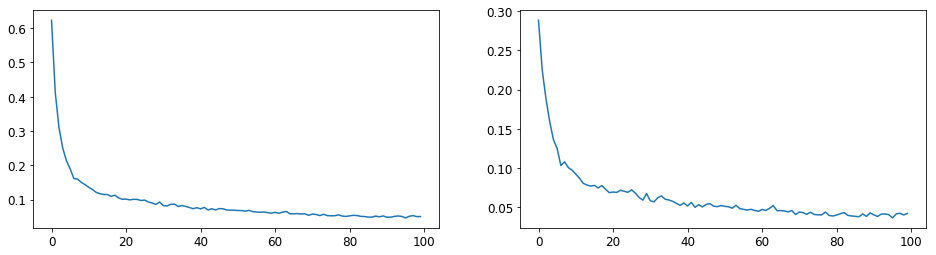

In [100]:
f, ax = plt.subplots(1, 2, figsize=(16, 4))
ax[0].plot(stds[:, 0])
ax[1].plot(stds[:, 1])